# X-Ray 폐렴 사진 이미지 분류

## 개요

- 사용 데이터: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)
- 데이터 구조
| 데이터셋 이름 | 설명 |
|----------------|-----------------------------|
| `train` | 모델 훈련용 |
| `val` | 모델 검증용 |
| `test` | 모델 테스트용 |

- 설계
| 태스크 | 기술 |
|----------------|-----------------------------|
| 데이터 전처리 | 데이터 로드, 전처리 |
| 모델 학습 및 예측 | 전이 학습 사용  |
| 성능 평가 | Accuracy, Precision, Recall, F1-score |

# 1. 데이터 전처리

In [ ]:
!pip install koreanize_matplotlib

   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ------ --------------------------------- 1.3/7.9 MB 7.4 MB/s eta 0:00:01
   ------------------ --------------------- 3.7/7.9 MB 9.5 MB/s eta 0:00:01
   ----------------------------- ---------- 5.8/7.9 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------  7.9/7.9 MB 10.4 MB/s eta 0:00:01
   ---------------------------------------- 7.9/7.9 MB 9.5 MB/s eta 0:00:00


In [ ]:
!pip install kagglehub

  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
Using cached kagglehub-0.3.13-py3-none-any.whl (68 kB)


In [ ]:
# 라이브러리 준비
from pathlib import Path

# 파이토치 관련
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchvision import models

# 클래스 불균형을 잡아주는 함수
from sklearn.utils.class_weight import compute_class_weight

# 평가지표용
from sklearn.metrics import confusion_matrix

# 시각화
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import koreanize_matplotlib

# 데이터셋 불러오기용
import kagglehub

c:\Users\Hosung\anaconda3\envs\htrans\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 데이터 불러오기
data_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print(f"데이터 경로 확인: {data_path}")

100%|██████████| 2.29G/2.29G [03:48<00:00, 10.8MB/s]

Extracting files...


데이터 경로 확인: C:\Users\Hosung\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [ ]:
# 경로 파일 구조 확인
def path_printer(path: str, prefix="") -> str:
    """
    인자:
    - 경로 스트링
    - 접두사

    출력:
    - 트리 구조의 디렉토리 스토링
    """
    # 경로 객체 선언
    path = Path(path)
    # iterdir로 경로 안 디렉토리 순회
    for dir in path.iterdir():
        # 폴더일 경우 그 안에서 함수 호출
        if dir.is_dir():
            print(prefix + dir.name)
            path_printer(dir, prefix + "  ")

path_printer(data_path)


chest_xray
  chest_xray
    test
      NORMAL
      PNEUMONIA
    train
      NORMAL
      PNEUMONIA
    val
      NORMAL
      PNEUMONIA
  test
    NORMAL
    PNEUMONIA
  train
    NORMAL
    PNEUMONIA
  val
    NORMAL
    PNEUMONIA
  __MACOSX
    chest_xray
      test
        NORMAL
        PNEUMONIA
      train
        NORMAL
        PNEUMONIA
      val
        NORMAL
        PNEUMONIA


In [ ]:
# 디바이스 변수 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [ ]:
# 데이터셋 분할
train_path = Path(f"{data_path}/chest_xray/train")
val_path = Path(f"{data_path}/chest_xray/val")
test_path = Path(f"{data_path}/chest_xray/test")

In [ ]:
# 샘플 이미지 시각화 함수
def imagination(path: Path):
    # path 아래에 있는 폴더 두 개 리스트에 담기
    dirs = sorted([p for p in path.iterdir() if p.is_dir()]) # -> 두 path 객체로 이루어진 리스트
    x_dir, y_dir = dirs

    # 파일 목록을 리스트에 답기
    x_files = sorted(list(x_dir.iterdir()))
    y_files = sorted(list(y_dir.iterdir()))

    fig, axes = plt.subplots(3, 2, figsize=(5, 5))
    for i in range(3):
          x_image = Image.open(x_files[i]).convert("RGB")
          axes[i, 0].imshow(x_image)
          axes[i, 0].set_title(f"정상", fontsize=10)
          axes[i, 0].axis('off')

          y_image = Image.open(y_files[i]).convert("RGB")
          axes[i, 1].imshow(y_image)
          axes[i, 1].set_title(f"페렴", fontsize=10)
          axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

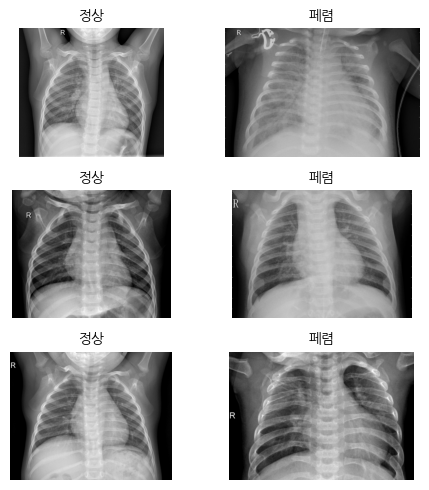

In [ ]:
# 샘플 이미지 시각화
imagination(train_path)

In [ ]:
# transform 객체 생성
train_transformer = v2.Compose([
    v2.Resize((256, 256)),
    v2.CenterCrop((224, 224)),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_transformer = v2.Compose([
    v2.Resize((256, 256)),
    v2.CenterCrop((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])


# ImageFolder = 폴더 구조를 자동으로 읽어서 (이미지, 라벨) 형태의 PyTorch Dataset으로 만들어주는 클래스
train_dataset = ImageFolder(train_path, transform=train_transformer)
val_dataset = ImageFolder(val_path, transform=test_transformer)
test_dataset = ImageFolder(test_path, transform=test_transformer)

In [ ]:
# 데이터로더 생성
train_dataloader = DataLoader(train_dataset, 16, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = DataLoader(val_dataset, 16, shuffle=False, num_workers=2, drop_last=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, num_workers=2, drop_last=False)

In [ ]:
# 클래스명 확인
class_names = train_dataset.classes
class_names

['NORMAL', 'PNEUMONIA']

# 2. 모델링

## 2.1. ResNet 18 사용

In [ ]:
# 사전학습 ResNet18 가져오기
def my_resnet(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Feature Extraction 사전학습 가중치 고정
    for name, param in model.named_parameters():
        if "layer4" in name or "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # 마지막 FC 계층만 가중치 학습 ON
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model

In [ ]:
# 클레스 불균형에 한 가중치 조절
weights = compute_class_weight(class_weight='balanced', # class_weight='balanced'로 각 클래스 등장 빈도에 맞추어서 가중치 조절
                               classes=np.array([0,1]), # 클래스 인덱스 명시
                               y=train_dataset.targets) # 데이터셋의 정답 라벨 범위
weights = torch.tensor(weights, dtype=torch.float32).to(device)


In [ ]:
# 모델 인스턴스화, 손실함수, 최적화 알고리즘 생성
my_model = my_resnet().to(device)
# fc 계층 파라미터만 최적화 알고리즘에 넘기기(10의 -5승)
optimizer = optim.Adam([p for p in my_model.parameters() if p.requires_grad], lr=1e-5)
loss_fn = nn.CrossEntropyLoss(weight=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Hosung/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:04<00:00, 11.1MB/s]


In [ ]:
# 훈련 및 검증용 클래스 생성
class train_or_test:
    """
    훈련과 테스트를 위한 클래스

    인자
    - model: 사용할 모델
    - optim; 최적화 알고리즘
    - loss_fn: 손실함수
    - epochs: 에포크 수 (기본 20)
    - save_file: 모델 저장 시 파일명
    - device: 사용할 디바이스
    - dataloader: train, eval, test 데이터로더
    """
    def __init__(self, model, optim, loss_fn, epochs=20, save_file="my_model", device=None, **dataloader):
        self.model = model
        self.optim = optim
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.device = device
        self.save_file = save_file
        self.train_loader = dataloader["train_loader"]
        self.val_loader = dataloader["val_loader"]
        self.test_loader = dataloader["test_loader"]

    def training_loop(self):
        # early stopping 구조 도입
        # 무한수("inf") float을 초기 할당
        best_val_loss = float('inf')
        patience = 10
        counter = 0

        for epoch in range(self.epochs):
            self.model.train()
            training_loss = 0
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # 그레디언트 초기화
                self.optim.zero_grad()

                output = self.model(inputs)
                # hasattr(obj, "속성이름")으로 로짓 속성 가져오기
                pred = output.logits if hasattr(output, "logits") else output
                loss = self.loss_fn(pred, labels)
                loss.backward()
                self.optim.step()

                training_loss += loss.item()

            print(f"에포크 [{epoch+1}/{self.epochs}], 훈련 손실: {training_loss/len(self.train_loader):.4f}")

            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for v_inputs, v_labels in self.val_loader:
                    v_inputs, v_labels = v_inputs.to(self.device), v_labels.to(self.device)

                    v_output = self.model(v_inputs)
                    v_pred = v_output.logits if hasattr(v_output, "logits") else v_output
                    v_loss = self.loss_fn(v_pred, v_labels)

                    val_loss += v_loss.item()

            print(f"에포크 [{epoch+1}/{self.epochs}], 검증 손실: {val_loss/len(self.val_loader):.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # 추후 사용 시 model.load_state_dict(torch.load(f"{self.save_file}.pth", weights_only=True))로 불러오기 가능
                torch.save(self.model.state_dict(), f"{self.save_file}.pth")
                counter = 0  # 인내심 초기화
            else:
                counter += 1
                print(f"조기 종료까지 {counter}/{patience}")
                if counter >= patience:
                    break

    def inference(self):
        self.model.eval()

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                t_output = self.model(inputs)
                logits = t_output.logits if hasattr(t_output, "logits") else t_output

                # CrossEntropyLoss일 경우 argmax
                preds = torch.argmax(logits, dim=-1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        print("Confusion Matrix:")
        print(confusion_matrix(all_labels, all_preds))


In [ ]:
# 실행 준비
executer = train_or_test(my_model, optimizer, loss_fn, epochs=20, save_file="resmodel", device=device, train_loader=train_dataloader, val_loader=val_dataloader, test_loader=test_dataloader)

In [ ]:
executer.training_loop()

에포크 [1/20], 훈련 손실: 0.1753
에포크 [1/20], 검증 손실: 0.3651
에포크 [2/20], 훈련 손실: 0.1056
에포크 [2/20], 검증 손실: 0.3458
에포크 [3/20], 훈련 손실: 0.0927
에포크 [3/20], 검증 손실: 0.2550
에포크 [4/20], 훈련 손실: 0.0768
에포크 [4/20], 검증 손실: 0.2533
에포크 [5/20], 훈련 손실: 0.0540
에포크 [5/20], 검증 손실: 0.4060
조기 종료까지 1/10
에포크 [6/20], 훈련 손실: 0.0525
에포크 [6/20], 검증 손실: 0.4067
조기 종료까지 2/10
에포크 [7/20], 훈련 손실: 0.0425
에포크 [7/20], 검증 손실: 0.3419
조기 종료까지 3/10
에포크 [8/20], 훈련 손실: 0.0351
에포크 [8/20], 검증 손실: 0.3605
조기 종료까지 4/10
에포크 [9/20], 훈련 손실: 0.0289
에포크 [9/20], 검증 손실: 0.2887
조기 종료까지 5/10
에포크 [10/20], 훈련 손실: 0.0264
에포크 [10/20], 검증 손실: 0.2792
조기 종료까지 6/10
에포크 [11/20], 훈련 손실: 0.0209
에포크 [11/20], 검증 손실: 0.4564
조기 종료까지 7/10
에포크 [12/20], 훈련 손실: 0.0147
에포크 [12/20], 검증 손실: 0.3363
조기 종료까지 8/10
에포크 [13/20], 훈련 손실: 0.0185
에포크 [13/20], 검증 손실: 0.5151
조기 종료까지 9/10
에포크 [14/20], 훈련 손실: 0.0142
에포크 [14/20], 검증 손실: 0.5052
조기 종료까지 10/10


In [ ]:
my_model.load_state_dict(torch.load("resmodel.pth", map_location=device))

<All keys matched successfully>

In [ ]:
executer.inference()

Confusion Matrix:
[[146  88]
 [  1 389]]


### 결과

혼동 행렬  
| 범주 | 수 |
|-------|-------------|
| True Negative | 146 |  
| False Negative | 1 |
| True Positive | 389 |
| False Positive | 88 |
  
  
  
점수 표
| 점수 기준 | 점 |
|-------|-------------|
| Accuracy | 85.7 |  
| Precision | 81.5 |
| Recall | 99.7 |
| F1 score | 89.6 |


## 2.2 VIT 사용


참고사항
- ResNet는 컨볼루션 층에서 FC 층으로 내려가는 위계적 구조라서 "초반 레이어 freezing" 방식이 많이 쓰인다.
- Vision Transformer는 모든 패치 토큰이 attention으로 서로 섞이기 때문에 전체 파인튜닝 전략 사용
- 사용 모델: google/vit-base-patch16-224
- 허깅페이스 [링크](https://huggingface.co/google/vit-base-patch16-224)
- 위의 train_or_test에서는 resnet 모델이 로짓을 반환했으나 VIT 모델에서는 ImageClassifierOutput 객체를 반환해서 logit 추출 필요

In [ ]:
!pip install transformers

In [ ]:
# 허깅페이스에서 VIT 모델과 이미지 전처리기, 허깅페이스 Transformer 전용 훈련 프레임워크 가져오기
from transformers import ViTForImageClassification, ViTImageProcessor

In [ ]:
# VIT 모델 선언
vit_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

# 전체 파인튜닝
for p in vit_model.parameters():
    p.requires_grad = True

c:\Users\Hosung\anaconda3\envs\htrans\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Hosung\.cache\huggingface\hub\models--google--vit-base-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regul

In [ ]:
# 모델 구조 확인
vit_model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
# vit용으로 최적화 알고리즘 선언
optimizer_vit = optim.Adam(vit_model.parameters(), lr=1e-5)

In [ ]:
# 실행 준비
executer_vit = train_or_test(vit_model, optimizer_vit, loss_fn, epochs=20, save_file="vitmodel", device=device, train_loader=train_dataloader, val_loader=val_dataloader, test_loader=test_dataloader)

In [ ]:
# 훈련 루프
executer_vit.training_loop()

에포크 [1/20], 훈련 손실: 0.1394
에포크 [1/20], 검증 손실: 0.1808
에포크 [2/20], 훈련 손실: 0.0561
에포크 [2/20], 검증 손실: 0.4106
조기 종료까지 1/10
에포크 [3/20], 훈련 손실: 0.0355
에포크 [3/20], 검증 손실: 0.3160
조기 종료까지 2/10
에포크 [4/20], 훈련 손실: 0.0261
에포크 [4/20], 검증 손실: 0.1766
에포크 [5/20], 훈련 손실: 0.0108
에포크 [5/20], 검증 손실: 1.3357
조기 종료까지 1/10
에포크 [6/20], 훈련 손실: 0.0054
에포크 [6/20], 검증 손실: 0.2465
조기 종료까지 2/10
에포크 [7/20], 훈련 손실: 0.0057
에포크 [7/20], 검증 손실: 0.3282
조기 종료까지 3/10
에포크 [8/20], 훈련 손실: 0.0014
에포크 [8/20], 검증 손실: 0.2308
조기 종료까지 4/10
에포크 [9/20], 훈련 손실: 0.0183
에포크 [9/20], 검증 손실: 0.3793
조기 종료까지 5/10
에포크 [10/20], 훈련 손실: 0.0088
에포크 [10/20], 검증 손실: 0.1839
조기 종료까지 6/10
에포크 [11/20], 훈련 손실: 0.0006
에포크 [11/20], 검증 손실: 0.3633
조기 종료까지 7/10
에포크 [12/20], 훈련 손실: 0.0002
에포크 [12/20], 검증 손실: 0.3818
조기 종료까지 8/10
에포크 [13/20], 훈련 손실: 0.0002
에포크 [13/20], 검증 손실: 1.2272
조기 종료까지 9/10
에포크 [14/20], 훈련 손실: 0.0001
에포크 [14/20], 검증 손실: 0.6125
조기 종료까지 10/10


In [ ]:
vit_model.load_state_dict(torch.load("vitmodel.pth", map_location=device))

<All keys matched successfully>

In [ ]:
# 추론
executer_vit.inference()

Confusion Matrix:
[[148  86]
 [  2 388]]


### 결과

혼동 행렬  
| 범주 | 수 |
|-------|-------------|
| True Negative | 148 |  
| False Negative | 2 |
| True Positive | 388 |
| False Positive | 86 |
  
  
  
점수 표
| 점수 기준 | 점 |
|-------|-------------|
| Accuracy | 85.9 |  
| Precision | 81.8 |
| Recall | 99.5 |
| F1 score | 89.8 |


In [ ]:
# 분류 시각화 함수 생성
def classification_visualization(model, dataloader, device, class_names, num_images=6):
    """
    함수 정의
    - 모델을 추론시키고, 이미지를 불러와 추론값과 함께 시각화

    인자
    - model: 사용 모델
    - dataloader: 데이터로더
    - device: 디바이스 변수
    - class_names: 데이터로더의 각 라벨 클래스명
    - num_images: 시각화할 이미지 수
    """
    model.eval()
    image_shown = 0

    plt.figure(figsize=(12, 12))
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 순전파
            output = model(inputs)
            logit = output.logits if hasattr(output, "logits") else output
            preds = torch.argmax(logit, dim=-1)

            # 이미지 불러오기
            # input.size(0)으로 배치 크기를 가져오기
            for i in range(inputs.size(0)):
                # 표시할 이미지 카운트
                image_shown += 1
                # num_images 넘길 시 종료
                if image_shown > num_images:
                    return

                # 배치의 i번째 이미지 가져오기
                img = inputs[i].to("cpu")
                # 역 정규화: 이미지 x 편차 + 평균
                img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                img = torch.clamp(img, 0, 1)

                # subplot 설정
                plt.subplot((num_images // 3 + 1), 3, image_shown)
                plt.imshow(img.permute(1, 2, 0).cpu().numpy())

                # 라벨 설정
                pred_label = class_names[preds[i].item()]
                true_label = class_names[labels[i].item()]
                color = "green" if pred_label == true_label else "red"

                plt.title(f"예측: {pred_label}\n라벨: {true_label}", color=color)
                plt.axis("off")

    plt.tight_layout()
    plt.show()

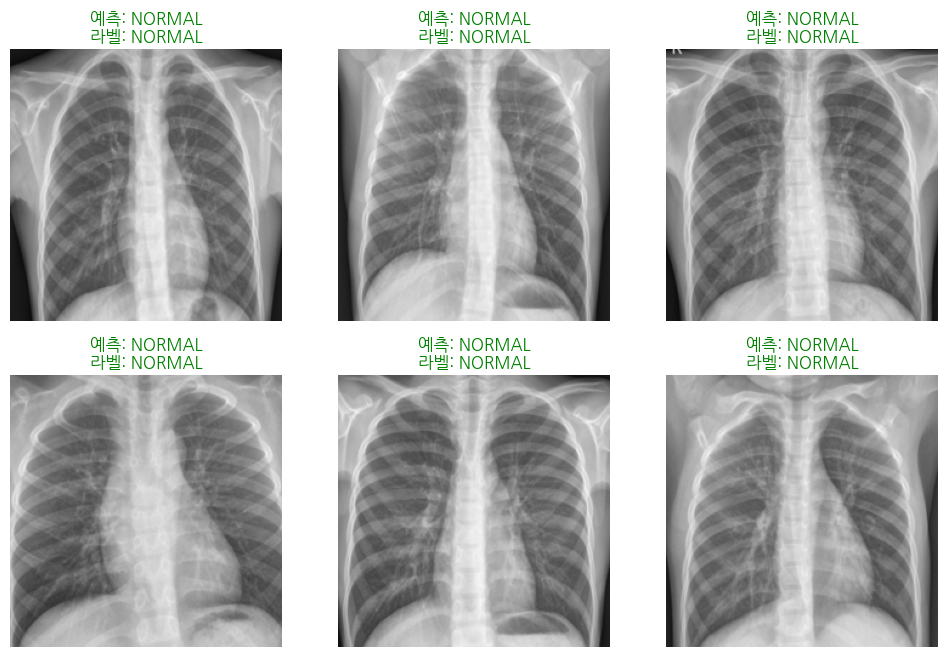

In [ ]:
# 시각화
classification_visualization(vit_model, test_dataloader, device, class_names)